## Multilabel with Segmentation U-Net, FCN & Mask RCNN

In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras as K
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing import image
from keras.callbacks import TensorBoard
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# Define utilites

# Prepare Dataset

In [2]:
df = pd.read_csv('data/label.csv')
df

,Filename,Label
0,image_1.jpg,"[Kerbau,Manusia]"
1,image_10.jpg,"[Kerbau,Manusia]"
2,image_100.jpg,[Kerbau]
3,image_101.jpg,"[Kerbau,Manusia]"
4,image_102.jpg,"[Kerbau,Manusia]"
...,...,...
2110,image_1999.jpg,"[Kerbau,Manusia,Truk]"
2111,image_2.jpg,"[Kerbau,Manusia]"
2112,image_20.jpg,"[Kerbau,Manusia]"
2113,image_200.jpg,[Kerbau]


In [3]:
# buat daftar unique dari semua label
unique_label = set()
for label in df["Label"]:
    label_list = label.strip("[]").split(",")
    for label in label_list:
        unique_label.add(label.strip())
        
# buatkan kolom one-hot encodinf setiap label
for label in unique_label:
    df[label] = df["Label"].apply(lambda x: int(label in x))

In [4]:
df.head()

,Filename,Label,Hewan liar,Manusia,Truk,Kerbau,Motor
0,image_1.jpg,"[Kerbau,Manusia]",0,1,0,1,0
1,image_10.jpg,"[Kerbau,Manusia]",0,1,0,1,0
2,image_100.jpg,[Kerbau],0,0,0,1,0
3,image_101.jpg,"[Kerbau,Manusia]",0,1,0,1,0
4,image_102.jpg,"[Kerbau,Manusia]",0,1,0,1,0


<Axes: xlabel='Label'>

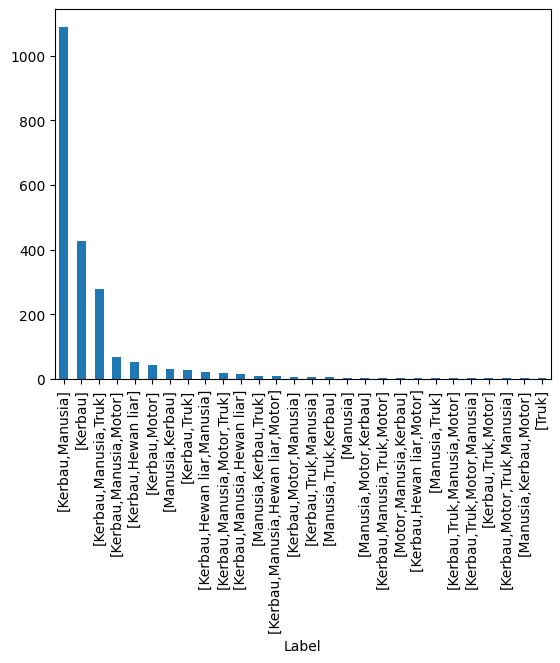

In [5]:
df['Label'].value_counts().plot(kind='bar')

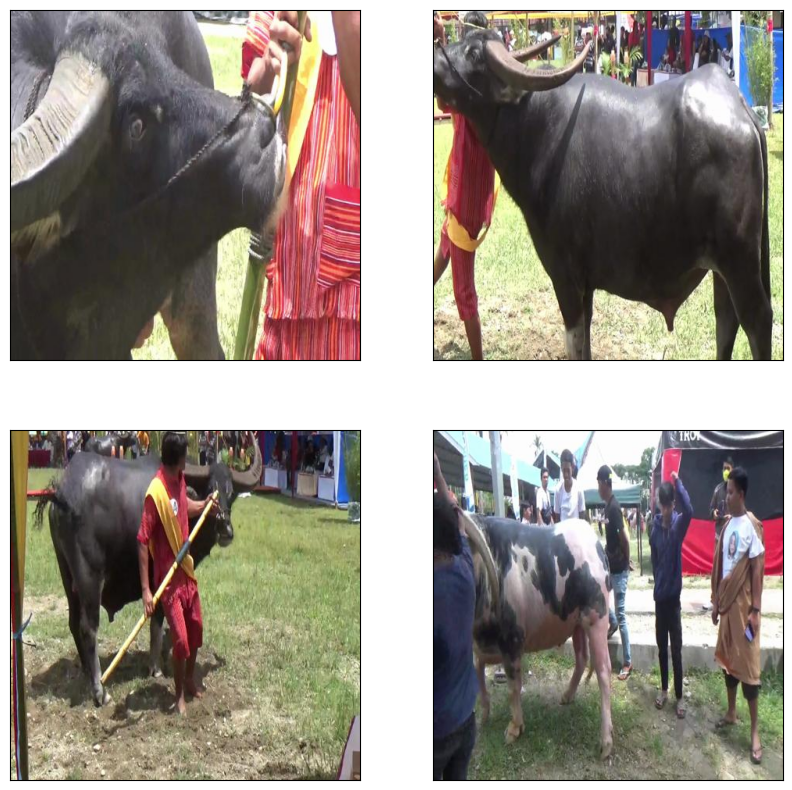

In [6]:
random_index = np.random.randint(0, len(df), 10)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                    subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread("data/image/"+ df.Filename[random_index[i]]))
plt.show()

In [7]:
# X_dataset = []
# for i in tqdm(range(df.shape[0])):
#     img = image.load_img('data/image/' + df["Filename"][i], target_size=(448, 448, 3))
#     img = image.img_to_array(img)
#     img /= 255.0
#     X_dataset.append(img)

In [8]:
# X = np.array(X_dataset)

In [9]:
# y = np.array(df.drop(columns=["Filename","Label"], axis=1))
# y

In [10]:
df["Filename"] = 'data/image/' + df["Filename"]
df.drop(columns='Label', axis=1, inplace=True)
df

,Filename,Hewan liar,Manusia,Truk,Kerbau,Motor
0,data/image/image_1.jpg,0,1,0,1,0
1,data/image/image_10.jpg,0,1,0,1,0
2,data/image/image_100.jpg,0,0,0,1,0
3,data/image/image_101.jpg,0,1,0,1,0
4,data/image/image_102.jpg,0,1,0,1,0
...,...,...,...,...,...,...
2110,data/image/image_1999.jpg,0,1,1,1,0
2111,data/image/image_2.jpg,0,1,0,1,0
2112,data/image/image_20.jpg,0,1,0,1,0
2113,data/image/image_200.jpg,0,0,0,1,0


In [11]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [12]:
train

,Filename,Hewan liar,Manusia,Truk,Kerbau,Motor
2072,data/image/image_1964.jpg,0,1,0,1,0
1549,data/image/image_1490.jpg,0,1,0,1,1
73,data/image/image_165.jpg,0,0,0,1,0
596,data/image/image_587.jpg,0,1,0,1,0
1107,data/image/image_1092.jpg,0,1,1,1,0
...,...,...,...,...,...,...
1638,data/image/image_1570.jpg,0,1,0,1,1
1095,data/image/image_1081.jpg,0,1,1,1,0
1130,data/image/image_1112.jpg,0,1,0,1,0
1294,data/image/image_1260.jpg,0,1,1,1,0


In [29]:
columns = ["Hewan liar", "Manusia",	"Truk", "Kerbau", "Motor"]

In [30]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# The value for class_mode in flow_from_dataframe MUST be 'raw' if you are attempting to do multilabel classification.
train_gen = train_datagen.flow_from_dataframe(train, 
                                              x_col='Filename', 
                                              y_col=columns,
                                              target_size=(224,224),
                                              class_mode='raw',
                                              batch_size=32,
                                              shuffle=True,
                                              subset='training')
val_gen = train_datagen.flow_from_dataframe(train,
                                          x_col='Filename',
                                          y_col=columns,
                                          target_size=(224,224),
                                          class_mode='raw',
                                          batch_size=16,
                                          subset='validation')
test_gen = test_datagen.flow_from_dataframe(test,
                                            x_col='Filename',
                                            y_col=columns,
                                            target_size=(224,224),
                                            class_mode='raw')

Found 1354 validated image filenames.
Found 338 validated image filenames.
Found 423 validated image filenames.


# Metrci Evaluations

# Define Loss

# U-Net

Berikut arsitektur keseluruhan U-Net yang akan digunakan:

<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet'>

UNet terdiri dari encoder (downsampler) dan decoder (upsampler) dengan hambatan di antaranya. Panah abu-abu sesuai dengan koneksi lompatan yang menggabungkan output blok encoder ke setiap tahap decoder.

### Encoder
Block-block encoder berisi 2 layer Conv2D diakttifkan oleh relu, serta di ikuti oleh MaxpPooling dan Dropout

In [15]:
def conv2d_block(input_tensor, n_filter, kernel_size=3):
    ''' 
    Arg:
    input_tensor (tensor) - tensor masukan
    n_filter (int) - jumlah filter
    kernel_size (int) -- ukuran kernel untuk konvolusi

    return
    tensor dari fitur keluaran
    '''
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters=n_filter, kernel_size=(kernel_size, kernel_size),\
                                    kernel_initializer="he_normal",padding='same')(x)
        x = tf.keras.layers.Activation("relu")(x)
    return x

def encoder_block(inputs, n_filter=64, pool_size=2, dropout=0.3):
    '''
    Arg:
    input (tensor) - tensor masukan
    n_filter (int) - jumlah filter
    pool_size - ukuran pool size
    dropout - jumlah yang ingin di dropout/buang

    return
    f - fitur keluaran dari block conv
    p - fitur yang dikumpulkan di MaxPooling dengan DropOut
    '''
    f = conv2d_block(inputs, n_filter=n_filter)
    p = tf.keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size))(f)
    p = tf.keras.layers.Dropout(dropout)(p)
    return f, p

def encoder(inputs):
    '''
    Arg:
    inputs - masukkan gambar

    return
    p4 - fitur yang dikumpulkan dari keseluruhan encoder block
    (f1, f2, f3, f4) - fitur yang dikeluarkan dari semua encoder block
    '''
    f1, p1 = encoder_block(inputs, n_filter=64, pool_size=2, dropout=0.3)
    f2, p2 = encoder_block(p1, n_filter=128, pool_size=2, dropout=0.3)
    f3, p3 = encoder_block(p2, n_filter=256, pool_size=2, dropout=0.3)
    f4, p4 = encoder_block(p3, n_filter=512, pool_size=2, dropout=0.3)
    return p4, (f1, f2, f3, f4)


### Bottleneck
Sebuah bottleneck mengikuti blok encoder dan digunakan untuk mengekstrak lebih banyak fitur. Ini tidak memiliki lapisan penyatuan sehingga dimensinya tetap sama.

In [16]:
def bottleneck(inputs):

    x = conv2d_block(inputs, n_filter=1024)
    return x

### Decoder
 decoder yang meng-upsampling fitur kembali ke ukuran gambar asli. Pada setiap tingkat upsampling, akan mengambil output dari blok encoder yang sesuai dan menggabungkannya sebelum memasukkannya ke blok decoder berikutnya

In [17]:
def decoder_block(inputs, conv_output, n_filter=64, kernel_size=3, strides=2, dropout=0.3):
    '''
    Arg:
    inputs (tensor) - kumpulan fitur input
    conv_output (tensor) - fitur dari blok encoder
    n_filter (int) -- jumlah filter
    kernel_size (int) -- ukuran kernel
    strides (int) -- langkah untuk dekonvolusi/upsampling
    padding (string) - "sama" atau "valid", memberi tahu apakah bentuk akan dipertahankan dengan padding nol

    return
    c (tensor) - fitur keluaran dari blok decoder
    '''
    u = tf.keras.layers.Conv2DTranspose(n_filter, kernel_size, strides=strides, padding='same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filter, kernel_size=3)

    return c

def decoder(input, convs, output_channels):
    '''
    Arg:
    inputs (tensor) - kumpulan fitur input
    convs (tuple) -- fitur dari blok penyandi
    output_channels (int) -- jumlah kelas dalam peta label
    activation (softmax/sigmoid,etc) - aktifasi yang dipakai

    return
    output (tensor) -- peta label berdasarkan piksel dari gambar
    '''
    f1, f2, f3, f4 = convs

    c6 = decoder_block(input, f4, n_filter=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c7 = decoder_block(c6, f3, n_filter=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c8 = decoder_block(c7, f2, n_filter=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c9 = decoder_block(c8, f1, n_filter=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

    flatten = tf.keras.layers.Flatten()(c9)
    output =  tf.keras.layers.Dense(output_channels, activation='sigmoid')(flatten)
    return output


In [18]:
def unet(input_shape):
    '''
    Mendefinisikan UNet dengan menghubungkan encoder, bottleneck, dan decoder.

    args:
    input_shape (int)- besaran deminsi input
    output (int) - jumlah output yang dikeluarkna
    activation - aktifasi yang digunakan untuk klasifikasi
    '''

    input = tf.keras.layers.Input(shape=input_shape)
    encoder_output, convs = encoder(input)
    bottlenecks = bottleneck(encoder_output)
    outputs = decoder(bottlenecks, convs, output_channels=5)

    model = tf.keras.Model(inputs=input, outputs=outputs)
    return model

In [19]:
auc = tf.keras.metrics.AUC(multi_label=True,thresholds=[0,0.5])
aucpr = tf.keras.metrics.AUC(curve='PR',multi_label=True,thresholds=[0,0.5])
model_uNet = unet(input_shape=(448, 448, 3,))
model_uNet.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=["accuracy", auc, aucpr])

In [20]:
model_uNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 448, 448, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 448, 448, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [21]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Input, UpSampling2D, concatenate
def UNet(inputs):
    # First convolution block
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    d1_con = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    d1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d1_con)
    
    # Second convolution block
    d2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d1)
    d2_con = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d2)
    d2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d2_con)
    
    # Third convolution block
    d3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d2)
    d3_con = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d3)
    d3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d3_con)
    
    # Fourth convolution block
    d4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d3)
    d4_con = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d4)
    d4 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d4_con)
    
    # Bottleneck layer
    b = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d4)
    b = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(b)
    
    # First upsampling block
    u1 = tf.keras.layers.Conv2DTranspose(512, 3, strides =(2,2),padding='same')(b)
    u1 = tf.keras.layers.concatenate([u1, d4_con])
    u1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u1)
    u1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u1)
    
    # Second upsampling block
    u2 = tf.keras.layers.Conv2DTranspose(256, 3, strides =(2,2),padding='same')(u1)
    u2 = tf.keras.layers.concatenate([u2, d3_con])
    u2 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u2)
    u2 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u2)
    
    # Third upsampling block
    u3 = tf.keras.layers.Conv2DTranspose(128, 3, strides =(2,2),padding='same')(u2)
    u3 = tf.keras.layers.concatenate([u3, d2_con])
    u3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u3)
    u3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u3)
    
    # Fourth upsampling block
    u4 = tf.keras.layers.Conv2DTranspose(64, 3, strides =(2,2),padding='same')(u3)
    u4 = tf.keras.layers.concatenate([u4, d1_con])
    u4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u4)
    u4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u4)
    
    # Flatten and output
    flat = tf.keras.layers.Flatten()(u4)
    out = tf.keras.layers.Dense(units=5, activation='sigmoid')(flat)
    model = tf.keras.Model(inputs=[inputs], outputs=[out])
    return model

In [22]:
inputs = tf.keras.layers.Input(shape=(448, 448, 3))
model = UNet(inputs)
model.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=["accuracy", auc, aucpr])

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 448, 448, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 448, 448, 64  36928       ['conv2d_18[0][0]']              
                                )                                                           

In [24]:
# model = unet()
# model.compile(optimizer='adam', loss=bce_dice_loss,
#                    metrics=["accuracy", dice_coef])
# model.summary()

In [25]:
%load_ext tensorboard

In [26]:
import datetime
def tensorboard_callback(name):
    logdir = os.path.join("Tensorboard/logs", datetime.datetime.now().strftime(f"%Y-%m-%d-{name}"))
    return TensorBoard(logdir)

class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, accuracy=0.9):
        self.accuracy = accuracy
        
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("val_accuracy") > self.accuracy:
            print(f"\nAkurasi telah mencapai {self.accuracy}%")
            self.model.stop_training = True

In [32]:
with tf.device("/device:GPU:0"):
    history1 = model.fit(train_gen,
                        # steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=50,
                              validation_data=val_gen,
                            #   validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("uNet"),
                              myCallback(accuracy=0.9)])

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'model_1/conv2d_transpose_4/conv2d_transpose' defined at (most recent call last):
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\lab-fikom\AppData\Local\Temp\ipykernel_12248\1945432266.py", line 2, in <module>
      history1 = model.fit(train_gen,
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\layers\convolutional\conv2d_transpose.py", line 296, in call
      outputs = backend.conv2d_transpose(
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\backend.py", line 6119, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(
Node: 'model_1/conv2d_transpose_4/conv2d_transpose'
Conv2DSlowBackpropInput: Size of out_backprop doesn't match computed: actual = 14, computed = 28 spatial_dim: 1 input: 56 filter: 3 output: 14 stride: 2 dilation: 1
	 [[{{node model_1/conv2d_transpose_4/conv2d_transpose}}]] [Op:__inference_train_function_4271]

In [ ]:
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Dense, Flatten


model = tf.keras.Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(448,448,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
# batch_size = 32
# with tf.device("/device:GPU:0"):
#     history1 = model.fit(x_train,
#                               y_train,
#                               steps_per_epoch=len(x_train) // batch_size,
#                               epochs=50,
#                               validation_data=(x_test, y_test),
#                               validation_steps=len(x_test) // batch_size,
#                               batch_size=batch_size,
#                               callbacks=[tensorboard_callback("uNet"),
#                               myCallback(accuracy=0.9)])